In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import edward as ed
import tensorflow as tf
plt.style.use('bmh')

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


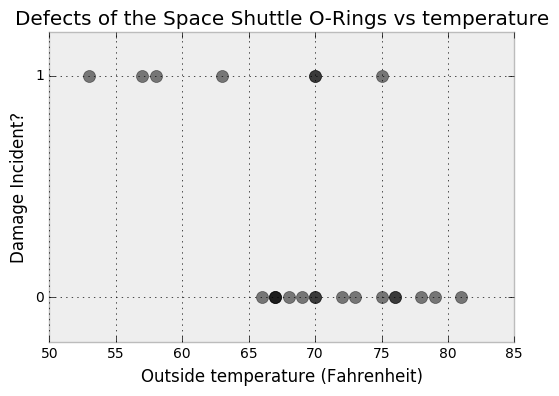

In [2]:
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

In [3]:
def logistic(x,beta,alpha=0):
    return 1.0 / (1.0+tf.exp(tf.matmul(x,beta)+alpha))

In [4]:
temperature = challenger_data[:,0]
t_temp = tf.reshape(np.float32(challenger_data[:,0]),[-1,1])
D = challenger_data[:,1]
t_D = tf.reshape(np.float32(challenger_data[:,1]),[-1,1])

beta = ed.models.Normal(loc=tf.zeros([1,1]),scale=tf.ones([1,1]))
alpha = ed.models.Normal(loc=tf.zeros(1),scale=tf.ones(1))
p = logistic(t_temp,beta,alpha)

In [55]:
qbeta = ed.models.Normal(loc=tf.Variable(tf.random_normal([1,1],0,1)),scale=tf.Variable(tf.random_normal([1,1],0,1)))
qalpha = ed.models.Normal(loc=tf.Variable(tf.random_normal([1],-20,1)),scale=tf.Variable(tf.random_normal([1],-20,1)))

In [56]:
inputs = np.linspace(50, 85, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [logistic(x,beta,alpha)
     for _ in range(10)])
mus=tf.reshape(mus,[10,400])

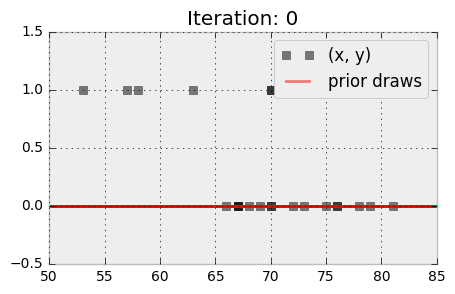

In [57]:
# FIRST VISUALIZATION (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(temperature, D, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([50, 85])
ax.set_ylim([-0.5, 1.5])
ax.legend()
plt.show()

In [ ]:
y = ed.models.Bernoulli(probs=logistic(t_temp,beta,alpha),dtype=tf.float32)

inference = ed.KLqp({beta:qbeta, alpha:qalpha},{y:t_D})
inference.run(n_iter=120000, n_samples=10000)

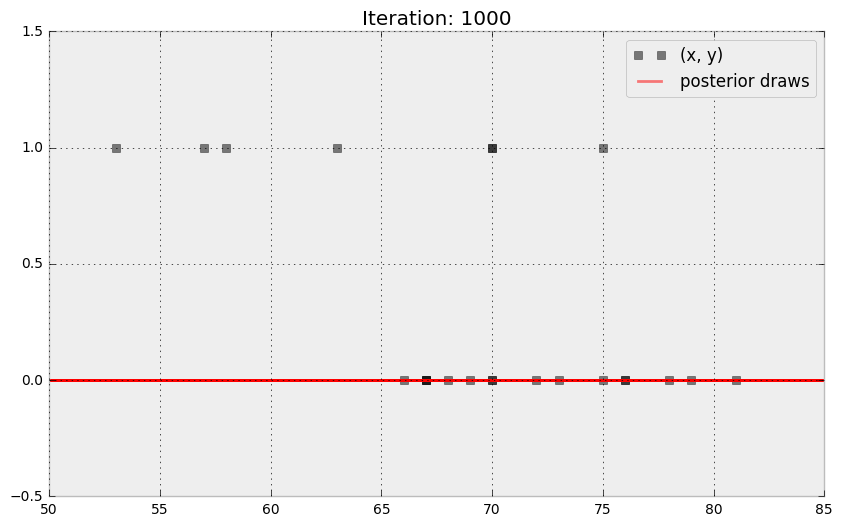

In [59]:
# SECOND VISUALIZATION (posterior)

outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(temperature, D, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([50, 85])
ax.set_ylim([-0.5, 1.5])
ax.legend()
plt.show()